In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [33]:
df = pd.read_csv('E:/training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [34]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [35]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [36]:
df.duplicated().sum()

16309

In [37]:
df.drop_duplicates(inplace=True)

In [38]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [39]:
df.rename(columns={'sentiment': 'label'}, inplace=True)
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [40]:
df = df.replace(4, 1)
print(df.loc[1200000])

label                                                    1
text     danielle is the best thing since cheese in a c...
Name: 1200000, dtype: object


In [41]:
remove_n = 1500000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)

In [42]:
print("Size:", len(df))

Size: 83691


Text(0.5, 1.0, 'Sarcasm Data Distribution')

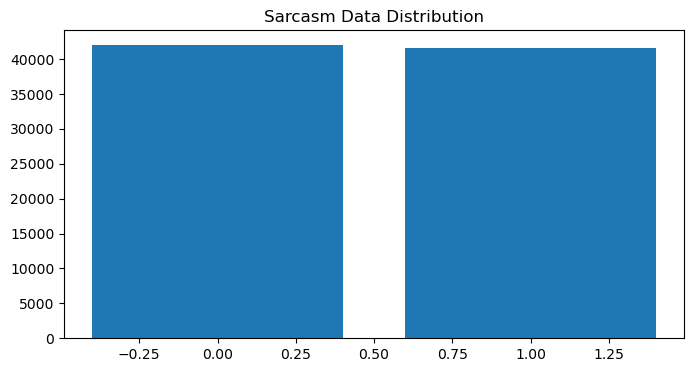

In [43]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sarcasm Data Distribution")

# Split & Train

In [1]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline
from datasets import Dataset
import evaluate

In [45]:
sentences = df['text']
label = df['label']

In [46]:
TRAIN_SIZE = 0.8

In [47]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=42) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 66952
Test Data size 16739


In [48]:
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

In [49]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [50]:
def tokenize(data):
   return tokenizer(data["text"], max_length=30, truncation=True, padding="max_length")
 
train_data = hg_train_data.map(tokenize)
test_data = hg_test_data.map(tokenize)

Map:   0%|          | 0/66952 [00:00<?, ? examples/s]

Map:   0%|          | 0/16739 [00:00<?, ? examples/s]

In [51]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
training_args = TrainingArguments(
    output_dir="./sentiment_transformer/",          
    logging_dir='./sentiment_transformer/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=3,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [54]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

  0%|          | 0/25107 [00:00<?, ?it/s]

{'loss': 0.4515, 'grad_norm': 17.55236053466797, 'learning_rate': 3.3333333333333333e-06, 'epoch': 1.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.43782949447631836, 'eval_accuracy': 0.8134297150367406, 'eval_runtime': 316.8497, 'eval_samples_per_second': 52.829, 'eval_steps_per_second': 6.606, 'epoch': 1.0}
{'loss': 0.3865, 'grad_norm': 13.749539375305176, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.431194931268692, 'eval_accuracy': 0.824422008483183, 'eval_runtime': 362.7109, 'eval_samples_per_second': 46.15, 'eval_steps_per_second': 5.77, 'epoch': 2.0}
{'loss': 0.3518, 'grad_norm': 22.163307189941406, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.44917961955070496, 'eval_accuracy': 0.824720712109445, 'eval_runtime': 274.5662, 'eval_samples_per_second': 60.965, 'eval_steps_per_second': 7.623, 'epoch': 3.0}
{'train_runtime': 25105.4235, 'train_samples_per_second': 8.001, 'train_steps_per_second': 1.0, 'train_loss': 0.3965959190757309, 'epoch': 3.0}


TrainOutput(global_step=25107, training_loss=0.3965959190757309, metrics={'train_runtime': 25105.4235, 'train_samples_per_second': 8.001, 'train_steps_per_second': 1.0, 'total_flos': 1558996395963840.0, 'train_loss': 0.3965959190757309, 'epoch': 3.0})

In [56]:
tokenizer.save_pretrained('./sentiment_tokenizer_transformer/')
trainer.save_model('./sentiment_trainer_transformer/')

import pickle
with open(r'E:/Research ML/LSTM_SarcasmDetection.pkl', 'wb') as file:  
    pickle.dump(model, file)